**Ritajit Majumdar**<br>
Enabling Technologies Researcher @ IBM Quantum<br>
majumdar.ritajit@ibm.com

## Understanding dynamical decoupling on hardware

In this notebook we shall take a circuit of interest, vary its number of qubits and depth, and apply dynamical decoupling (DD) on it. The aim of this exercise is to get a feel for

<ul>
    <li>In which scenario applying DD leads to effective error suppression</li>
    <li>Which DD sequence is most effective</li>
</ul>

For this study we shall select a TwoLocal circuit which is often used in problems related to quantum chemistry and quantum machine learning. Moreover, we shall use a compute-uncompute version of the circuit. In this, the circuit unitary $U$ is followed by $U^{\dagger}$ so that the ideal noiseless outcome is $|0\rangle^{\otimes n}$ for an $n$-qubit circuit.

The advantage of such a circuit is that the ideal expectation values for $Z$ type observables are known without explicit simulation which is not possible for utility-scale circuits. The disadvantage is that having an uncompute unitary doubles the depth of the base circuit.

## Qiskit Pattern

### Step 1: Map problem to quantum hardware native format

**Virtual circuit**

We start by declaring an example circuit. Feel free to change it to something else.

We select a circuit which is similar to the `TwoLocal` circuit which is often used in QML studies. A `TwoLocal` circuit has one linear chain of CNOTs, sandwitched between layers of single qubit parameterized gates. In this study, we shall modify that circuit to include more than one chain of CNOTs. The number of chains will allow us the vary the `density` of the circuit.

Let us first see the circuit with only the main diagonal.

In [144]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def construct_circuit(num_qubits:int, num_diagonals:int, measurement:bool=False, barrier:bool=True) -> QuantumCircuit:
    """
        This function constructs the circuit given the number of qubits and the number of diagonals
        num_qubits: total number of qubits in the circuit, expected to be odd
        num_diagonals: this circuit can accommodate 2.(num_qubits/2) diagonals.
                       the input to this variable should be 1 <= num_diagonals <= num_qubits/2
                       this value will be multiplied by 2 to insert a diagonal both to the
                       upper and lower halves of the main diagonal.

        density of the circuit is defined by num_diagonals/num_qubits
    """
    
    assert num_qubits%2 == 0, "the number of qubits should be even"
    assert num_diagonals >= 1 and num_diagonals <= num_qubits/2, "the number of diagonals should be between 1 and num_qubits/2"
    
    virtual_circuit = QuantumCircuit(num_qubits)
    params = ParameterVector("θ", 2*num_qubits)

    # 1st layer of single qubit gates
    for idx in range(num_qubits):
        virtual_circuit.ry(params[idx], idx)
    if barrier:
        virtual_circuit.barrier()

    # the entangling layers
    if num_diagonals == 1: # only the main diagonal
        for i in range(0, num_qubits-1):
            virtual_circuit.cx(i,i+1)

    if num_diagonals > 1:
        # the lower diagonals
        for diag in range(num_diagonals-1, 0, -1):
            for i in range(2*diag,num_qubits-1):
                virtual_circuit.cx(i,i+1)

        # the main diagonal
        for i in range(0, num_qubits-1):
            virtual_circuit.cx(i,i+1)

        # the upper diagonal
        for diag in range(num_diagonals-1):
            for i in range(num_qubits-2*diag-3):
                virtual_circuit.cx(i,i+1)

    return virtual_circuit

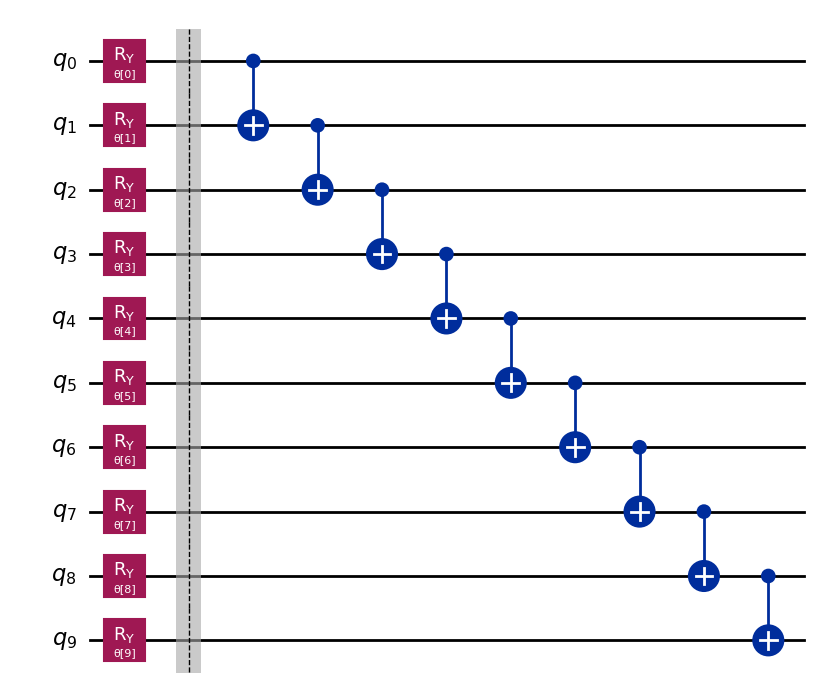

In [149]:
virtual_circuit = construct_circuit(10, 1)
virtual_circuit.draw('mpl',fold=-1)

Note now that it is possible to add diagonals to the left and right of the main diagonal, thus increasing the density of the circuit. As per the circuit construction, when we increase the number of diagonals to, say 2, then the circuit contains the main diagonal, and one diagonal is added to both the left and the right of the main diagonal. Therefore, the parameter `num_diagonals` is one more than the number of diagonals added to each side of the main diagonal. The total number of such diagonals is equal to the number of qubits in the circuits. Therefore, as per our convention (add one diagonal to both sides of the main diagonal), `1 <= num_diagonals <= num_qubits/2`.<br>

Here, we show an example of a 10-qubit circuit with num_diagonals == 3.

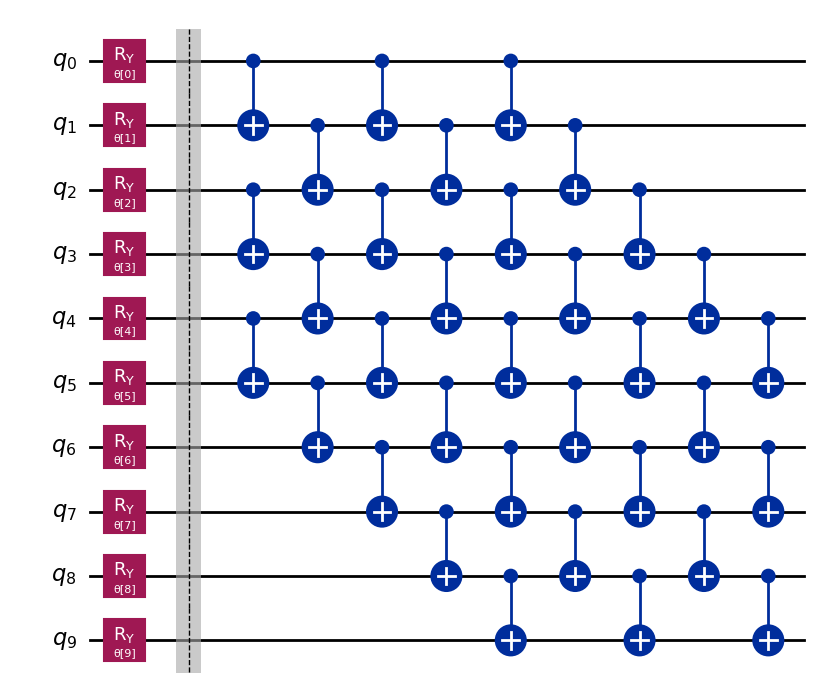

In [151]:
example_circuit = construct_circuit(10, 3)
example_circuit.draw('mpl',fold=-1)

`Density` of a circuit is defined as `(2*num_diagonals-1)/num_qubits`. Since `1 <= num_diagonals <= num_qubits/2`, we have `1/num_qubits <= density <= (num_qubits-1)/num_qubits`.

#### Create compute-uncompute circuit

We shall use the `virtual_circuit` with `num_diagonals = 1` for the rest of the example in this notebook.

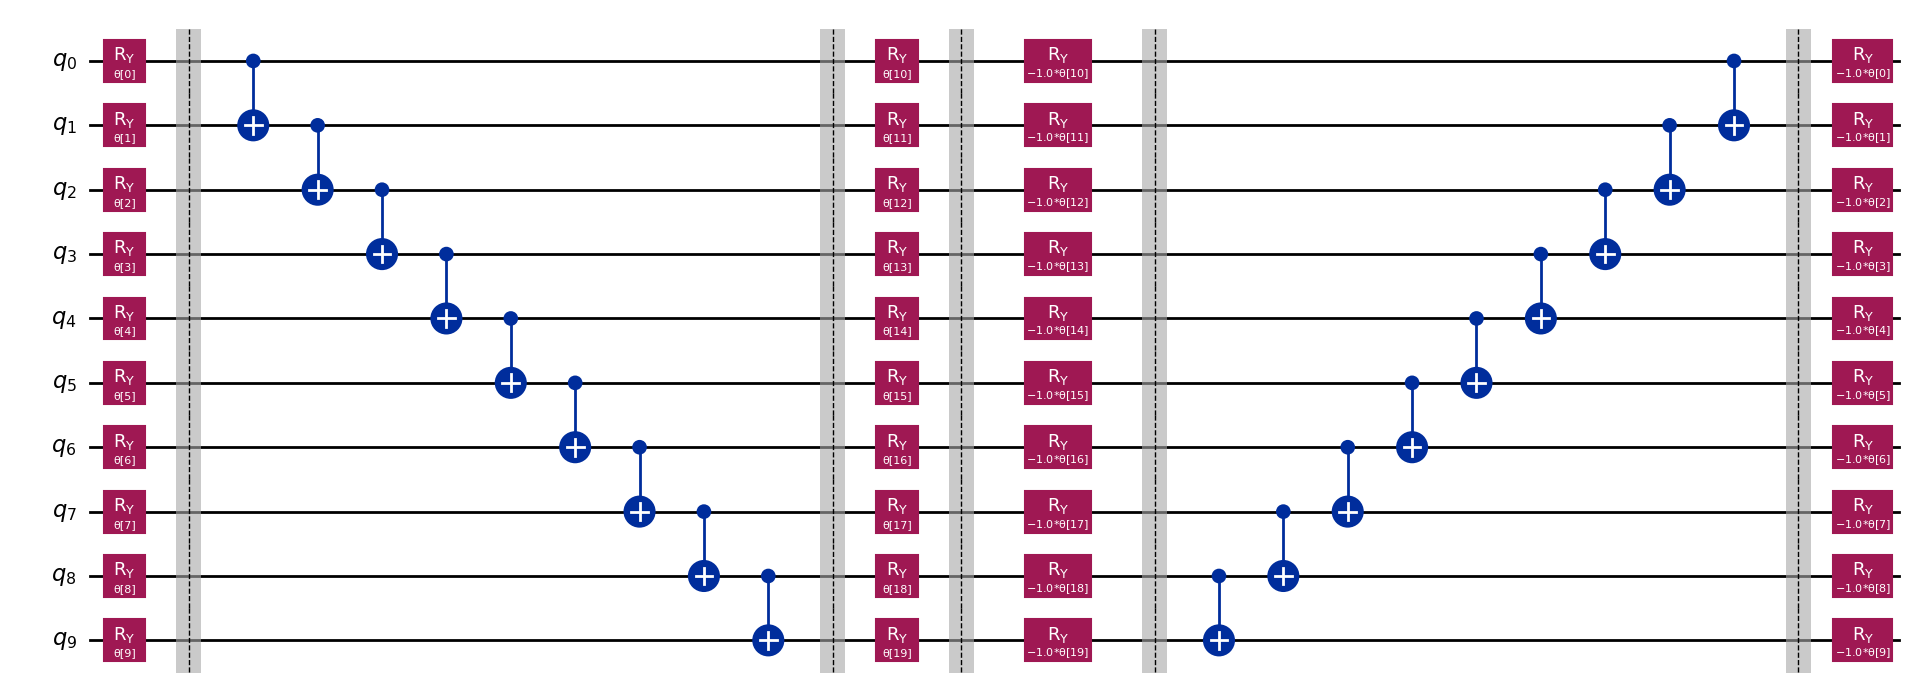

In [3]:
inverse = virtual_circuit.inverse()
virtual_circuit.barrier()
virtual_circuit.compose(inverse, inplace=True)

virtual_circuit.draw('mpl',fold=-1)

#### Assign parameters

We shall assign parameters randomly to this circuit. Note that since the circuit is of type compute-uncompute, the ideal outcome of the circuit is independent of the exact values of the parameters.

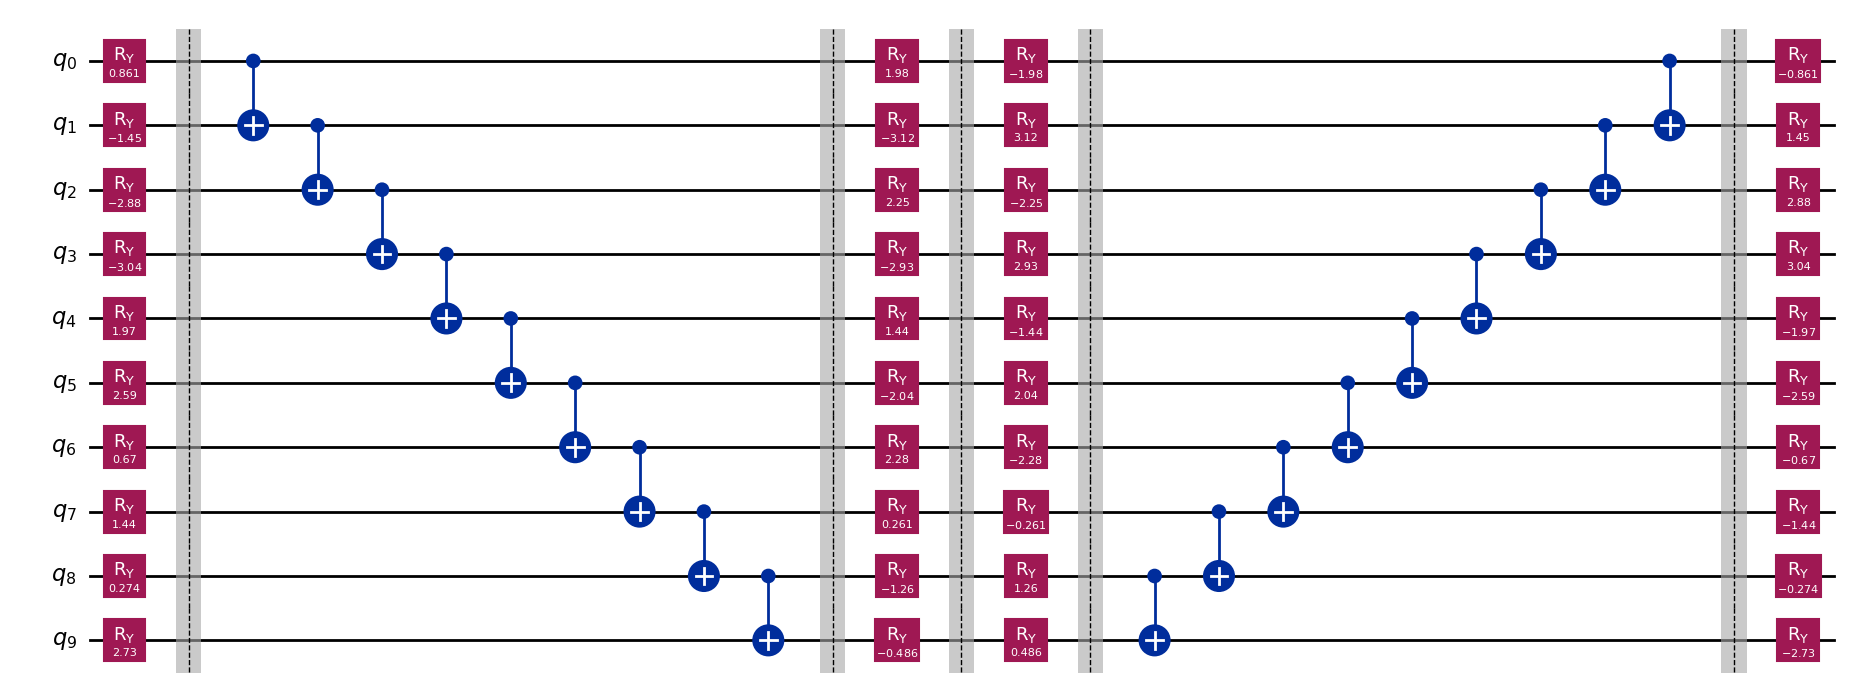

In [4]:
from numpy import pi
from numpy.random import default_rng

rng = default_rng(seed=0)
parameter_values = rng.uniform(-pi, pi, size=virtual_circuit.num_parameters)
virtual_circuit.assign_parameters(parameter_values, inplace=True)

virtual_circuit.draw(output='mpl', fold=-1)

#### Observables

Let us select the average of all weight-1 Pauli-Z observables for this example. Note that by nature of the compute-uncompute circuit the ideal value is exactly 1.

In [5]:
from qiskit.quantum_info import SparsePauliOp

paulis = ['I'*i + 'Z' + 'I'*(num_qubits-i-1) for i in range(num_qubits)]
coeffs = 1/len(paulis)

observable = SparsePauliOp(paulis, coeffs)
print(observable)

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])


### Step 2: Optimize circuit and observable

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()  # Credentials may be needed
backend = service.get_backend('ibm_kyiv')  # Choose your desired backend

#### Physical circuit (transpilation)

In order to execute the logical circuit on actual hardware we need to express it in terms of the hardware's native gates (i.e. Instruction Set Architecture, ISA), as well as assign physical qubits for execution. This action is carried out through the process of circuit transpilation.

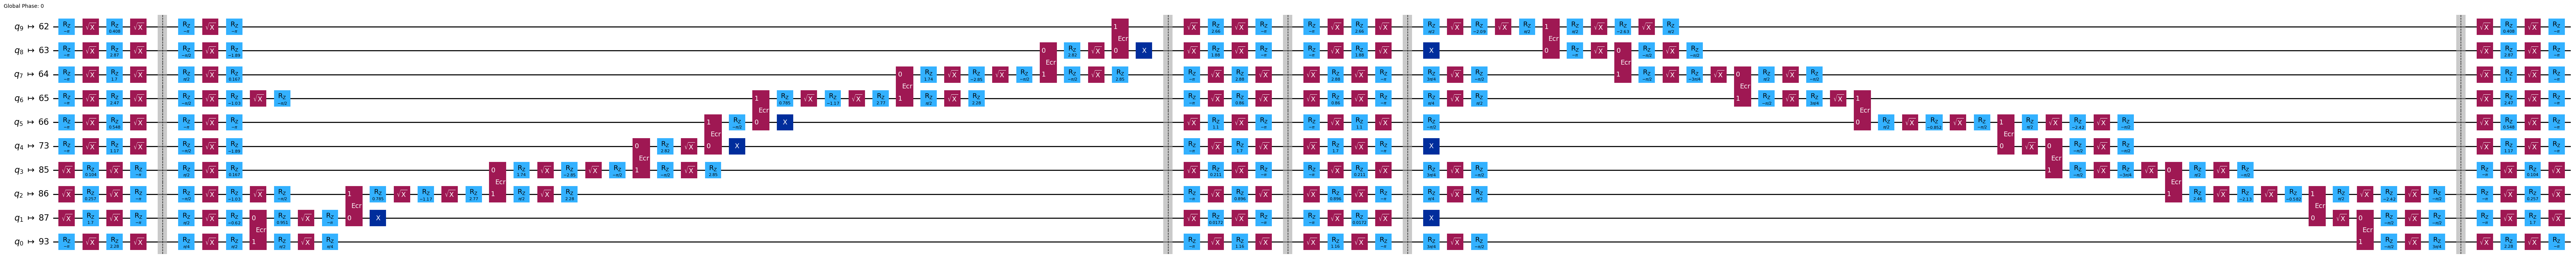

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
physical_circuit = pm.run(virtual_circuit)

physical_circuit.draw(output='mpl', fold=-1, idle_wires=False)

#### Physical observable (layout)

In the same way that we needed to adapt our logical circuit to the hardware, we will need to adapt the associated logical observable in an equivalent way. The resulting physical observable will need to account for the additional qubits in the hardware, as well as for any routing that the logical qubits may have experienced when mapped on to physical ones. This can be easily done by applying the physical circuit's layout to the logical observable. We refer to this process as *observable layout*.

In [8]:
physical_layout = physical_circuit.layout
physical_observable = observable.apply_layout(physical_layout)

print(physical_observable)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIII

### Step 3: Execute using Qiskit Primitives

#### Dynamical decoupling

Note that in the original circuit, most of the qubits remain idle for a significant amount of time while other qubits are involved in gate operations. Such idle qubits are susceptible to crosstalk appearing from the gate operations on other qubits. Therefore, dynamical decoupling appends some single qubit gate operations on these idle timespans to avoid such crosstalk. The sequence of gates appended to the idle timestamp must cummulatively lead to identity to ensure functional equivalence.

#### Execute

Now we shall execute the circuit using an `EstimatorV2` primitive. The dynamical decoupling shall be applied using the primitive itself. Qiskit currently allows three DD sequences -- namely `XX`, `XpXm` and `XY4`. We shall run the circuit with each of these DD sequence, and also without any DD. We shall not use any other error mitigation or suppression technique for this notebook.

In [14]:
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()

options.default_shots = 4096
options.optimization_level = 0  # Deactivate error suppression
options.resilience_level = 0  # Deactivate error mitigation

In [17]:
from qiskit_ibm_runtime import Batch, EstimatorV2

jobs = {}
with Batch(backend=backend) as batch:
    estimator = EstimatorV2(session=batch, options=options)
    pub = (physical_circuit, physical_observable)

    # No DD
    estimator.options.dynamical_decoupling.enable = False
    jobs['no_dd'] = estimator.run([pub])

    # DD with XX pulse sequence
    dd_sequence = 'XX'
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

    # DD with XpXm pulse sequence
    dd_sequence = 'XpXm'
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

    # DD with XY4 pulse sequence
    dd_sequence = 'XY4'
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

In [18]:
print("JOB IDS:")
for dd_sequence, job in jobs.items():
    print(f"  - {job.job_id()} ({dd_sequence})")

JOB IDS:
  - csc0ew33dkhg008ze3m0 (no_dd)
  - csc0ewkzx1qg008m9hs0 (XX)
  - csc0ex3tj7dg008cbcs0 (XpXm)
  - csc0exbx35wg0080yk3g (XY4)


### Step 4: Postprocess

Let us observe the expectation values obtained for different DD sequences

In [20]:
results = {dd_sequence: job.result()[0] for dd_sequence, job in jobs.items()}
evs = {dd_sequence: result.data.evs.tolist() for dd_sequence, result in results.items()}

print("EXPECTATION VALUES:")
for dd_sequence, ev in evs.items():
    print(f"  - {ev} ({dd_sequence})")

EXPECTATION VALUES:
  - 0.19667968750000003 (no_dd)
  - 0.574072265625 (XX)
  - 0.5982910156250001 (XpXm)
  - 0.6757324218749999 (XY4)


### Practice

#### Challenge 1

Run the above example over (i) multiple days and (ii) different times of the day. Verify whether the best DD sequence, and the obtained expectation value varies over time.

P.S. Since the method is statistical, and noise is not deterministic, it is better to run the circuit with the same DD pulse multiple times and report the mean and the standard deviation of the expectation value for each case.

#### Challenge 2

When the circuit becomes `too dense`, the idle time is hardly significant for the DD pulse to show any improvement, rather the insertion of single qubit gates will increase the gate noise. We can verify how dense is `too dense`.<br>

Create a circuit with a particular value of `num_qubits` and vary the `density` of the circuit. For each `density` report

<ol>
    <li>the DD pulse which leads to the best expectation value</li>
    <li>whether the obtained expectation value from the best DD pulse is better than the scenario where no DD is applied</li>
</ol>

#### Challenge 3

Vary the number of qubits and the density of the circuit. For each case, apply DD pulse and use measurement error mitigation by setting `resilience_level` to 1. Report whether the inclusion of measurement error mitigation can minimize the difference in performance between the cases when DD is and is not applied.